In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Fer+ Balanced

# New Load

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_data = datasets.ImageFolder("/data/raf/train", transform=transform)
val_data = datasets.ImageFolder("/data/raf/val", transform=transform)
test_data = datasets.ImageFolder("/data/raf/test", transform=transform)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class_names = train_data.classes
print("✅ Classes:", class_names)


✅ Classes: ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'suprise']


In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:


# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze backbone (optional)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(class_names))
)

model = model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


Epoch 1/10 | Avg Loss: 1.5431 | Train Acc: 0.4220 | Val Acc: 0.4838
Epoch 2/10 | Avg Loss: 1.4004 | Train Acc: 0.4810 | Val Acc: 0.5265
Epoch 3/10 | Avg Loss: 1.3415 | Train Acc: 0.5053 | Val Acc: 0.5416
Epoch 4/10 | Avg Loss: 1.3042 | Train Acc: 0.5185 | Val Acc: 0.5538
Epoch 5/10 | Avg Loss: 1.2806 | Train Acc: 0.5282 | Val Acc: 0.5460
Epoch 6/10 | Avg Loss: 1.2481 | Train Acc: 0.5401 | Val Acc: 0.5753
Epoch 7/10 | Avg Loss: 1.2307 | Train Acc: 0.5470 | Val Acc: 0.5772
Epoch 8/10 | Avg Loss: 1.1997 | Train Acc: 0.5576 | Val Acc: 0.5678
Epoch 9/10 | Avg Loss: 1.1882 | Train Acc: 0.5605 | Val Acc: 0.5806
Epoch 10/10 | Avg Loss: 1.1659 | Train Acc: 0.5689 | Val Acc: 0.5858


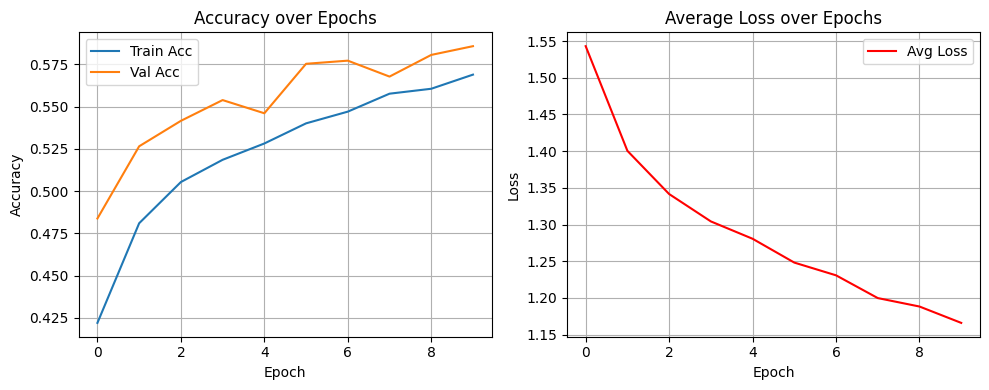

In [ ]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.5829

🔍 Classification Report:

              precision    recall  f1-score   support

       angry       0.45      0.45      0.45       898
    contempt       0.76      0.68      0.72       898
     disgust       0.76      0.54      0.63       898
        fear       0.64      0.63      0.64       898
       happy       0.64      0.61      0.63       898
     neutral       0.50      0.67      0.57       898
         sad       0.47      0.37      0.41       898
     suprise       0.54      0.71      0.61       898

    accuracy                           0.58      7184
   macro avg       0.60      0.58      0.58      7184
weighted avg       0.60      0.58      0.58      7184



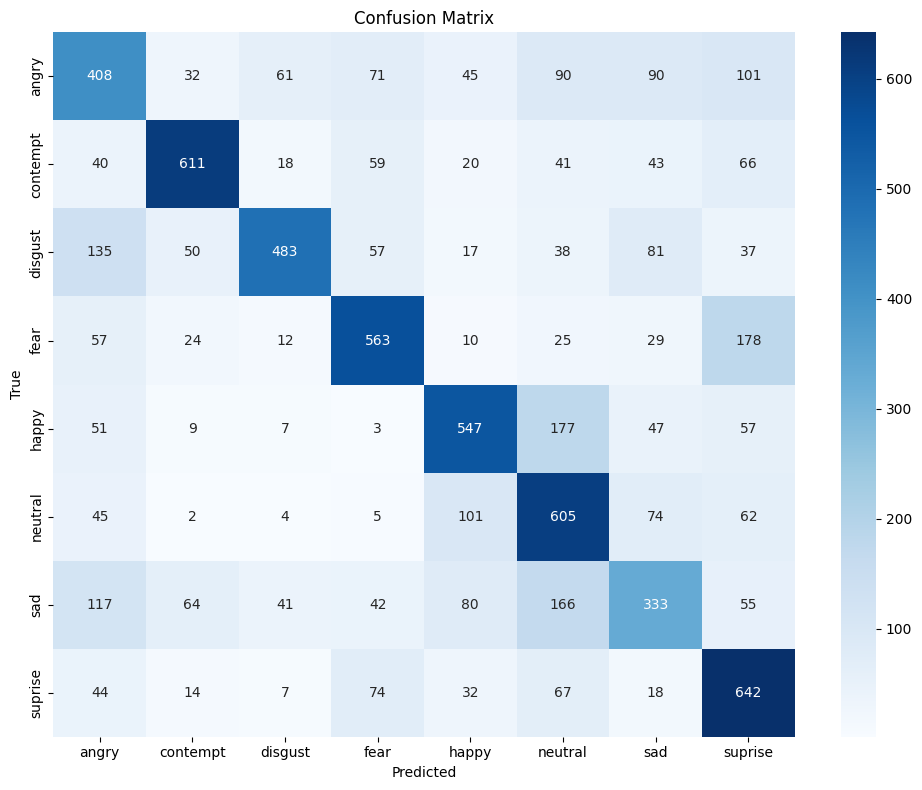

In [ ]:
from sklearn.metrics import f1_score , classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class names
class_names = test_data.classes

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Classification report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#20 epoch


Epoch 1/20 | Avg Loss: 1.5578 | Train Acc: 0.4154 | Val Acc: 0.4819
Epoch 2/20 | Avg Loss: 1.4005 | Train Acc: 0.4828 | Val Acc: 0.5207
Epoch 3/20 | Avg Loss: 1.3572 | Train Acc: 0.4993 | Val Acc: 0.5361
Epoch 4/20 | Avg Loss: 1.3110 | Train Acc: 0.5165 | Val Acc: 0.5496
Epoch 5/20 | Avg Loss: 1.2837 | Train Acc: 0.5262 | Val Acc: 0.5575
Epoch 6/20 | Avg Loss: 1.2675 | Train Acc: 0.5305 | Val Acc: 0.5475
Epoch 7/20 | Avg Loss: 1.2486 | Train Acc: 0.5374 | Val Acc: 0.5727
Epoch 8/20 | Avg Loss: 1.2260 | Train Acc: 0.5475 | Val Acc: 0.5768
Epoch 9/20 | Avg Loss: 1.2032 | Train Acc: 0.5520 | Val Acc: 0.5790
Epoch 10/20 | Avg Loss: 1.1918 | Train Acc: 0.5583 | Val Acc: 0.5844
Epoch 11/20 | Avg Loss: 1.1836 | Train Acc: 0.5640 | Val Acc: 0.5929
Epoch 12/20 | Avg Loss: 1.1600 | Train Acc: 0.5719 | Val Acc: 0.6028
Epoch 13/20 | Avg Loss: 1.1454 | Train Acc: 0.5781 | Val Acc: 0.5943
Epoch 14/20 | Avg Loss: 1.1366 | Train Acc: 0.5797 | Val Acc: 0.6083
Epoch 15/20 | Avg Loss: 1.1265 | Train Acc:

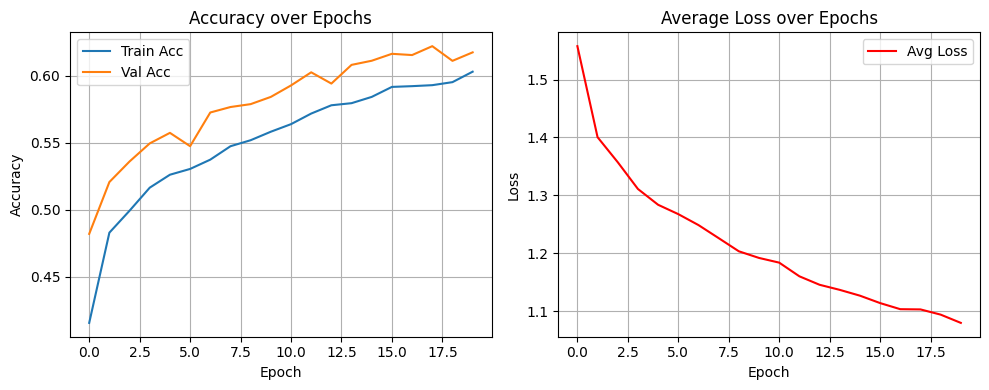

In [ ]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

✅ Weighted F1 Score: 0.6132

🔍 Classification Report:

              precision    recall  f1-score   support

       angry       0.61      0.41      0.49       898
    contempt       0.74      0.79      0.77       898
     disgust       0.61      0.80      0.69       898
        fear       0.62      0.72      0.67       898
       happy       0.70      0.60      0.65       898
     neutral       0.52      0.66      0.58       898
         sad       0.62      0.33      0.43       898
     suprise       0.60      0.66      0.63       898

    accuracy                           0.62      7184
   macro avg       0.63      0.62      0.61      7184
weighted avg       0.63      0.62      0.61      7184



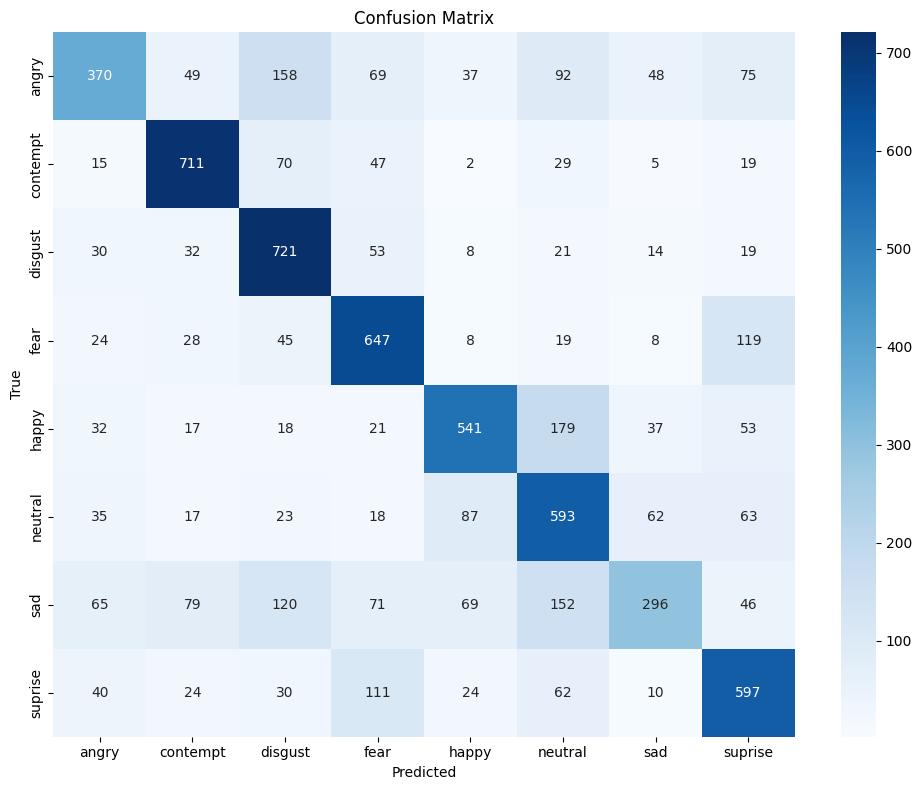

In [ ]:
from sklearn.metrics import f1_score , classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class names
class_names = test_data.classes

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Classification report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Entire ResNet50 Training

In [ ]:


# Load pretrained ResNet50
entire_model = models.resnet50(pretrained=True)

# Freeze backbone (optional) CHANGED FOR ENTIRE RESNET50 TRAINING
for param in entire_model.parameters():
    param.requires_grad = True

# Replace classifier head
entire_model.fc = nn.Sequential(
    nn.Linear(entire_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(class_names))
)

entire_model = entire_model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(entire_model.fc.parameters(), lr=1e-5)


Epoch 1/10 | Avg Loss: 1.8895 | Train Acc: 0.3135 | Val Acc: 0.4026
Epoch 2/10 | Avg Loss: 1.6724 | Train Acc: 0.4041 | Val Acc: 0.4402
Epoch 3/10 | Avg Loss: 1.5777 | Train Acc: 0.4304 | Val Acc: 0.4548
Epoch 4/10 | Avg Loss: 1.5203 | Train Acc: 0.4473 | Val Acc: 0.4692
Epoch 5/10 | Avg Loss: 1.4827 | Train Acc: 0.4600 | Val Acc: 0.4799
Epoch 6/10 | Avg Loss: 1.4523 | Train Acc: 0.4701 | Val Acc: 0.4896
Epoch 7/10 | Avg Loss: 1.4290 | Train Acc: 0.4811 | Val Acc: 0.4916
Epoch 8/10 | Avg Loss: 1.4104 | Train Acc: 0.4876 | Val Acc: 0.4990
Epoch 9/10 | Avg Loss: 1.3964 | Train Acc: 0.4927 | Val Acc: 0.5024
Epoch 10/10 | Avg Loss: 1.3813 | Train Acc: 0.4962 | Val Acc: 0.5050


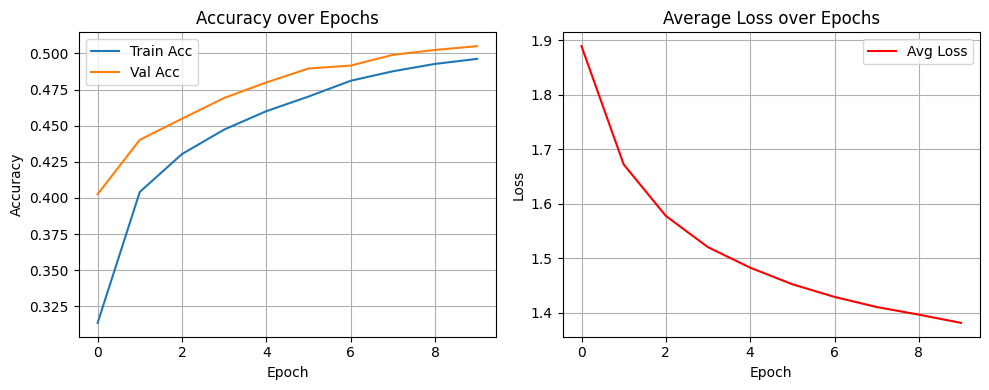

In [ ]:
entire_model = train_model(entire_model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.4943

🔍 Classification Report:

              precision    recall  f1-score   support

       angry       0.43      0.26      0.33       898
    contempt       0.49      0.54      0.52       898
     disgust       0.51      0.53      0.52       898
        fear       0.54      0.58      0.56       898
       happy       0.54      0.65      0.59       898
     neutral       0.48      0.54      0.51       898
         sad       0.41      0.35      0.38       898
     suprise       0.54      0.56      0.55       898

    accuracy                           0.50      7184
   macro avg       0.50      0.50      0.49      7184
weighted avg       0.50      0.50      0.49      7184



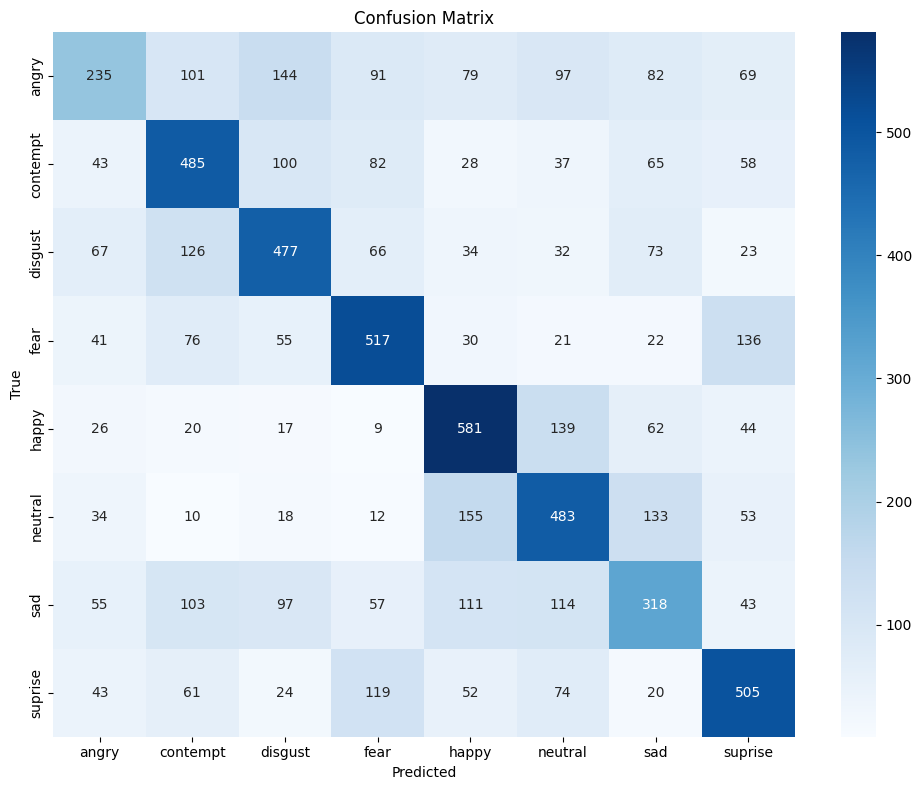

In [ ]:
from sklearn.metrics import f1_score , classification_report, confusion_matrix
import seaborn as sns

entire_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = entire_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class names
class_names = test_data.classes

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Classification report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Inception Model Training

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])


train_data = datasets.ImageFolder("/content/ferplus/train", transform=transform)
val_data = datasets.ImageFolder("/content/ferplus/val", transform=transform)
test_data = datasets.ImageFolder("/content/ferplus/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)


In [ ]:
from torchvision.models import inception_v3, Inception_V3_Weights

# Use latest recommended API
weights = Inception_V3_Weights.DEFAULT
inception = inception_v3(weights=weights, aux_logits=True)

# Freeze backbone
for param in inception.parameters():
    param.requires_grad = False

# Replace classifier
in_features = inception.fc.in_features
inception.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(train_data.classes))
)

inception = inception.to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 176MB/s]


In [ ]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inception.fc.parameters(), lr=1e-3)


In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            if isinstance(outputs, tuple):  # for InceptionV3
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 | Avg Loss: 1.6786 | Train Acc: 0.3631 | Val Acc: 0.4533
Epoch 2/10 | Avg Loss: 1.5806 | Train Acc: 0.4048 | Val Acc: 0.4587
Epoch 3/10 | Avg Loss: 1.5568 | Train Acc: 0.4157 | Val Acc: 0.4738
Epoch 4/10 | Avg Loss: 1.5323 | Train Acc: 0.4284 | Val Acc: 0.4868
Epoch 5/10 | Avg Loss: 1.5105 | Train Acc: 0.4354 | Val Acc: 0.5049
Epoch 6/10 | Avg Loss: 1.4936 | Train Acc: 0.4396 | Val Acc: 0.5127
Epoch 7/10 | Avg Loss: 1.4841 | Train Acc: 0.4466 | Val Acc: 0.5204
Epoch 8/10 | Avg Loss: 1.4677 | Train Acc: 0.4519 | Val Acc: 0.5166
Epoch 9/10 | Avg Loss: 1.4559 | Train Acc: 0.4575 | Val Acc: 0.5306
Epoch 10/10 | Avg Loss: 1.4452 | Train Acc: 0.4613 | Val Acc: 0.5345


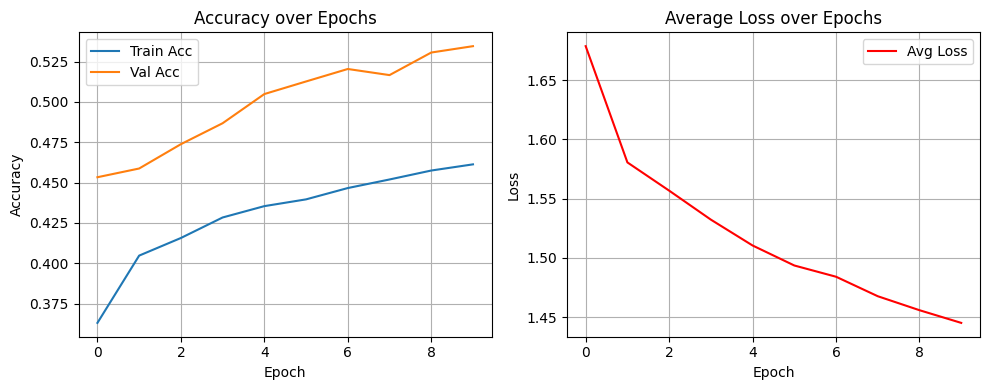

In [ ]:
inception = train_model(inception, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.5234

              precision    recall  f1-score   support

       angry       0.50      0.26      0.34       898
    contempt       0.61      0.67      0.64       898
     disgust       0.50      0.76      0.61       898
        fear       0.67      0.53      0.59       898
       happy       0.50      0.62      0.55       898
     neutral       0.45      0.56      0.50       898
         sad       0.45      0.32      0.37       898
     suprise       0.62      0.54      0.58       898

    accuracy                           0.53      7184
   macro avg       0.54      0.53      0.52      7184
weighted avg       0.54      0.53      0.52      7184



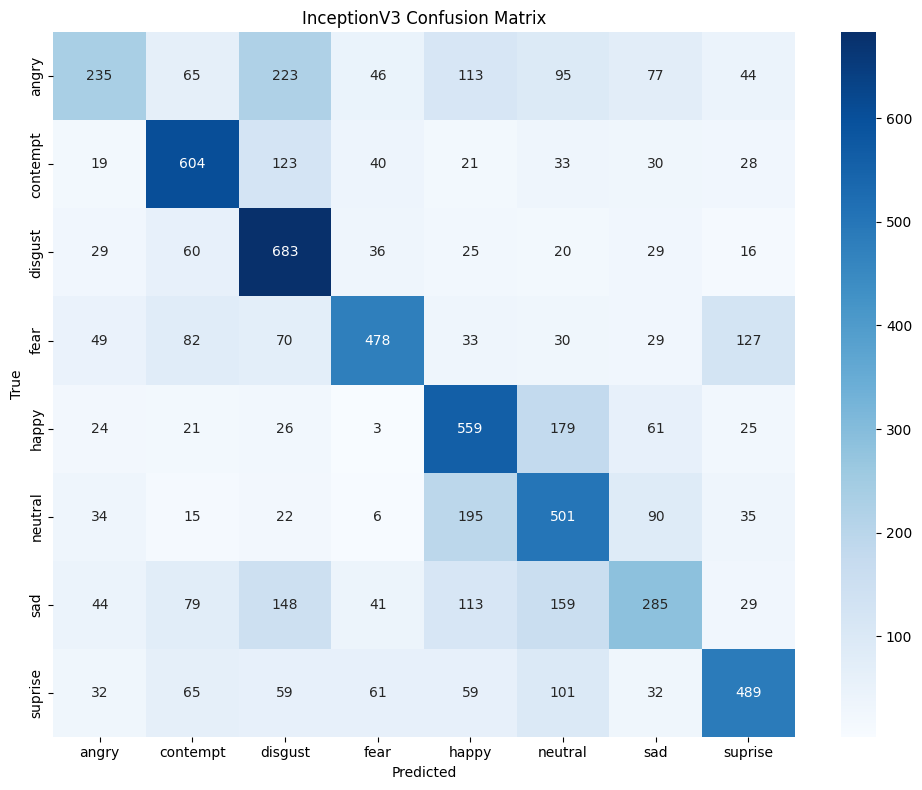

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Switch to eval mode
inception.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Classification Report
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap='Blues')
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
